In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../ventilator-pressure-prediction-data/train.csv')

In [3]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


Informationen über die Datentypen

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [5]:
train.isnull().any()

id           False
breath_id    False
R            False
C            False
time_step    False
u_in         False
u_out        False
pressure     False
dtype: bool

Hier sind Mittelwert und Standardabeichung wie in der Vorstellung der Daten zu sehen.

In [6]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [7]:
train['id'].duplicated().any()

False

**Individuelle Atemzüge**

Anzahl individueller Atemnzüge

In [8]:
unique_breaths = train['breath_id'].unique()
number_breaths = len(unique_breaths)
print(number_breaths)

75450


Mehrere Datenpunkte pro Atemzug

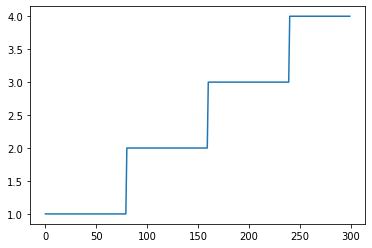

In [9]:
train['breath_id'][:300].plot();

Jeder Atemzug hat exakt 80 Datenpunkte

In [10]:
breath_lengths = train[['id','breath_id']].groupby('breath_id').count()['id']
breath_lengths.unique()

array([80])

Da alle Atemnzüge die selbe Länge haben, können wir diese als Konstante erstellen.

In [11]:
BREATH_LENGTH = breath_lengths.unique()[0]

**R und C, Lungeneigenschaften**

R und C sind inenrhalb eines Atemzuges kostant

In [12]:
r_c_std_in_breaths = train[['breath_id','R','C']].groupby('breath_id').std()
print(r_c_std_in_breaths['R'].unique())
print(r_c_std_in_breaths['C'].unique())

[0.]
[0.]


R hat 3 paarweise verschiedene Werte. Diese sind 5, 20 und 50, wie in der Datenvorstellung schon gesehen.

In [13]:
r_values = train[['breath_id', 'R']].groupby('breath_id').mean()['R']
print('Unique values:')
print(r_values.value_counts())

r_unique = np.sort(r_values.unique()).astype(int)

Unique values:
50.0    30126
5.0     24860
20.0    20464
Name: R, dtype: int64


C hat ebenfalls 3 paarweise verschiedene Werte. Diese sind 10, 20 und 50, wie in der Datenvorstellung schon gesehen. 

In [14]:
c_values = train[['breath_id', 'C']].groupby('breath_id').mean()['C']
print('Unique values:')
print(c_values.value_counts())

c_unique = np.sort(c_values.unique()).astype(int)

Unique values:
10.0    28059
50.0    24646
20.0    22745
Name: C, dtype: int64


Wie hängen nun die verschiedenen R und C Werte zusammen? 

Für R = 5 sind die drei C Werte gleichverteilt. 
Für R = 20 kommt C = 50 am häufigsten vor,
Für R = 50 ist C = 10 am häufigsten.

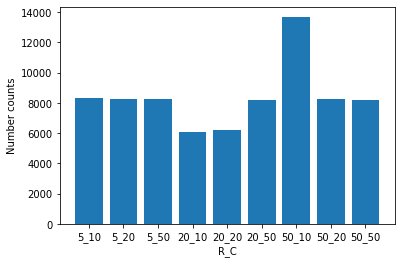

In [15]:
rc_values = np.array([
    [r, c, len(train[(train['R'] == r) & (train['C'] == c)])//BREATH_LENGTH] 
    for r in r_unique 
    for c in c_unique
])

x = range(len(rc_values))
plt.bar(x, rc_values[:,2])
plt.xticks(x, [str(r) + '_' + str(c) for r, c in rc_values[:,:2] ])
plt.xlabel('R_C')
plt.ylabel('Number counts')
plt.show()

Für C = 10 kommt R = 50 am häufigsten vor, 
Für C = 20 teilen sich R = 5 und R = 50 die meisten Counts, 
Für C = 50 sind die drei R Werte gleich verteilt.

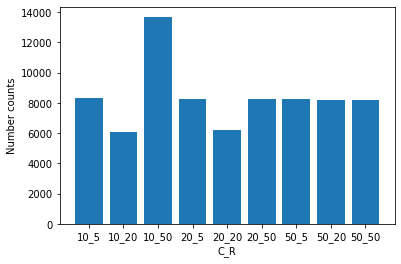

In [16]:
cr_values = np.array([
    [c, r, len(train[(train['C'] == c) & (train['R'] == r)])//BREATH_LENGTH] 
    for c in c_unique 
    for r in r_unique
])

x = range(len(cr_values))
plt.bar(x, cr_values[:,2])
plt.xticks(x, [str(c) + '_' + str(r) for c, r in cr_values[:,:2] ])
plt.xlabel('C_R')
plt.ylabel('Number counts')
plt.show()

**Individuelle Atemzüge**

Wie viele individuelle Atmenzüge gibt es??

In [17]:
unique_breaths = train['breath_id'].unique()
num_breaths = len(unique_breaths)
print(num_breaths)

75450


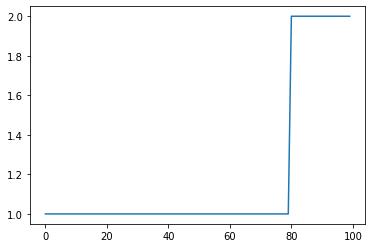

In [18]:
train['breath_id'][:100].plot();

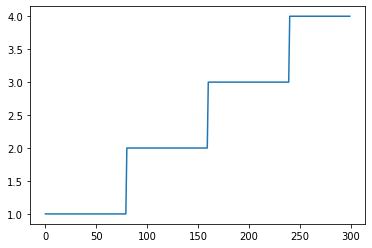

In [19]:
train['breath_id'][:300].plot();

Es sieht aus als wären alle Atmenzüge genau 80 Datenpunkte groß. 

In [20]:
breath_lengths = train[['id','breath_id']].groupby('breath_id').count()['id']
breath_lengths.unique()

array([80])

Ja, es gilt: Alle Atemzüge sind genau 80 Datenpunkte groß.

In [21]:
r_c_std_in_breaths = train[['breath_id','R','C']].groupby('breath_id').std()
print(r_c_std_in_breaths['R'].unique())
print(r_c_std_in_breaths['C'].unique())

[0.]
[0.]


Keine Standartabweichung innerhalb R und C. Daraus folgt: inenrhalb eines Atemzuges sind R und C konstant!|

**Time steps in individuellen Atmenzügen**

Wie sind die ersten beiden Atemzüge (als Beispiel) auf ihre Zeitschritte aufgeteilt?

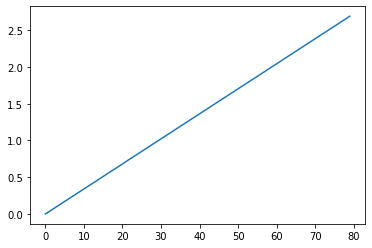

In [22]:
first_breath  = train[train['breath_id'] == 1]
second_breath = train[train['breath_id'] == 2]

x = range(BREATH_LENGTH)
t1 = first_breath['time_step']
t2 = second_breath['time_step']
plt.plot(x, t1)

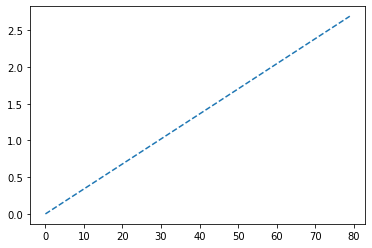

In [23]:
plt.plot(x, t2, ls = '--')

Sieht recht gleichmäßig aus. Trügt das?

Text(0, 0.5, 'Zeitdifferenz')

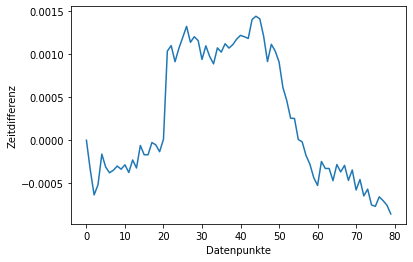

In [24]:
plt.plot(t1.values - t2.values);
plt.xlabel('Datenpunkte')
plt.ylabel('Zeitdifferenz')


Die ersten beien Atemzüge haben Unterschiede in ihrem zeitlichem Verlauf.

Keine Standartabweichung beim Startwert des Zeitschrittes: Alle Atemzüge starten bei 0.

In [25]:
train[['breath_id', 'time_step']].groupby('breath_id').min()['time_step'].std()

0.0

Wie lange ist ein Atemzug?

In [26]:
time_step_max = train[['breath_id', 'time_step']].groupby('breath_id').max()['time_step']
time_step_max.describe()

count    75450.000000
mean         2.614803
std          0.087102
min          2.496809
25%          2.523674
50%          2.655257
75%          2.689902
max          2.937238
Name: time_step, dtype: float64

Alle Atemzüge sind zwischen 2,5 und 2,9 Sekunden lang. 

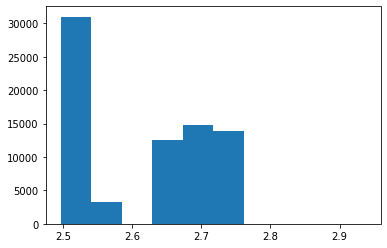

In [27]:
plt.hist(time_step_max);

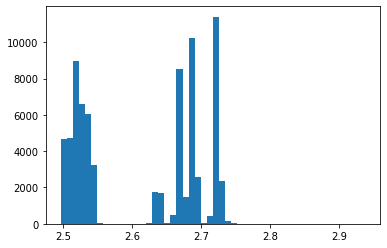

In [28]:
plt.hist(time_step_max, 50);

Alle Atemzüge haben 80 Datenpunkte, aber nicht die selbe Länge. Daraus folgt: nicht alle Zeitschritte sind gleich lang.

**Zeitschritt-Längen**

Wie sind nun die Zeitschrittlängen auf die einzelnen Atemzüge aufgeteitl?

In [29]:
def calc_dt(df : pd.DataFrame) -> pd.DataFrame:
    '''
    Includes a new feature for timeseries. Calculates the Time for each datastep.

    Args:
        df: Dataframe with timeseries named time_step.

    Returns:
        Dataframe with new feature.

    '''
    df['dt'] = df['time_step'].diff()
    time_step_size = df[df.dt >= 0]
    df['dt'] = time_step_size.dt
    return df

In [30]:
train = calc_dt(train)
train.dt.describe()

count    5.960550e+06
mean     3.309877e-02
std      1.232990e-03
min      3.144002e-02
25%      3.189349e-02
50%      3.345442e-02
75%      3.404546e-02
max      2.510931e-01
Name: dt, dtype: float64

Negative Werte: entstehen bei einem Übergang von einem Atemzug zum anderen und sollen nicht betrachtet werden. 
Warum der eine Ausreiser bei max? -> ist tatächlich einfach ein großer Sprung.

In [31]:
train[train.dt == train.dt.max()]

,id,breath_id,R,C,time_step,u_in,u_out,pressure,dt
2128959,2128960,44245,50,10,2.937238,4.996405,1,6.189002,0.251093


In [32]:
max_id = train[train.dt == train.dt.max()].id.max()
whats_up = train[(train.id <= (max_id + 5)) & (train.id > (max_id - 5))]
whats_up

,id,breath_id,R,C,time_step,u_in,u_out,pressure,dt
2128955,2128956,44245,50,10,2.591004,4.979698,1,6.329607,0.031732
2128956,2128957,44245,50,10,2.622747,4.982678,1,6.470211,0.031743
2128957,2128958,44245,50,10,2.654503,4.985221,1,6.118700,0.031755
2128958,2128959,44245,50,10,2.686145,4.987384,1,6.540513,0.031642
2128959,2128960,44245,50,10,2.937238,4.996405,1,6.189002,0.251093
2128960,2128961,44248,50,50,0.000000,28.258151,0,6.118700,NaN
2128961,2128962,44248,50,50,0.031781,27.465058,0,9.071390,0.031781
2128962,2128963,44248,50,50,0.063486,27.178008,0,11.321059,0.031704
2128963,2128964,44248,50,50,0.095173,26.335851,0,20.179129,0.031688
2128964,2128965,44248,50,50,0.127887,25.066763,0,27.420250,0.032713


Gibt es viele Ausreiser neben dem offensichtlichen Peak? Minimum bis 75%-Quantil haben alle ungefähr die selbe Größenordnung. Wieviele Punkte liegen jetzt also ganz außerhalb? 

Bis 0,05 sind es nur eine Handvoll Werte, diese können weggelassen werden? Gehen vielleicht noch mehr?

In [33]:
len(train[train['dt'] > 0.05])

30

In [34]:
len(train[train['dt'] > 0.0355])

5438

(array([181995., 166064., 146773., 119601., 109638., 101371.,  95779.,
         84728.,  79611.,  75781.,  67464.,  50582.,  32272.,  19995.,
         12730.,   8395.,   5604.,   3712.,   2568.,   2085.,   1893.,
          1807.,   2187.,   2846.,   3829.,   5394.,   7660.,  10127.,
         13587.,  15953.,  18765.,  20982.,  23525.,  28244.,  30174.,
         32922.,  31189.,  28117.,  24195.,  20090.,  16785.,  13839.,
         11207.,   8456.,   6135.,   3995.,   2481.,   1588.,    885.,
           608.]),
 array([0.03400016, 0.03403015, 0.03406014, 0.03409014, 0.03412013,
        0.03415012, 0.03418012, 0.03421011, 0.0342401 , 0.0342701 ,
        0.03430009, 0.03433008, 0.03436007, 0.03439007, 0.03442006,
        0.03445005, 0.03448005, 0.03451004, 0.03454003, 0.03457003,
        0.03460002, 0.03463001, 0.03466001, 0.03469   , 0.03471999,
        0.03474998, 0.03477998, 0.03480997, 0.03483996, 0.03486996,
        0.03489995, 0.03492994, 0.03495994, 0.03498993, 0.03501992,
        

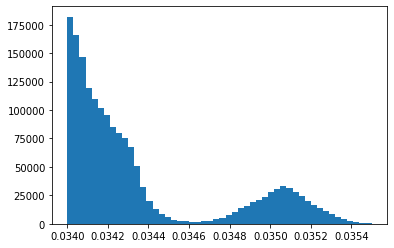

In [35]:
points_between_75_and_100 = train[(train['dt'] > 0.034) & (train['dt'] < 0.0355)].dt
plt.hist(points_between_75_and_100, 50) #np.arange(0.0, 1.0, 0.2))

So werden unter 0,1% alles Punkte als Outlier weggelassen. Das ist vermutlich ok? Mal sehen was noch so passiert. 

(array([1311783., 1054878.,   78776.,  257882.,  296109.,  662230.,
        1652829.,  256879.,  228584.,  155162.]),
 array([0.03144002, 0.031846  , 0.03225198, 0.03265796, 0.03306394,
        0.03346992, 0.03387589, 0.03428187, 0.03468785, 0.03509383,
        0.03549981]),
 <BarContainer object of 10 artists>)

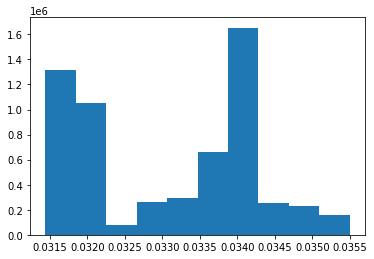

In [36]:
dt = train[(train['dt'] > 0.031) & (train['dt'] < 0.0355)].dt
plt.hist(dt)

Sind alle Datenpunkte gleichmäßig auf die Zeit eines Atemzuges verteilt? -> Berechnung mean und Standardabweichung.

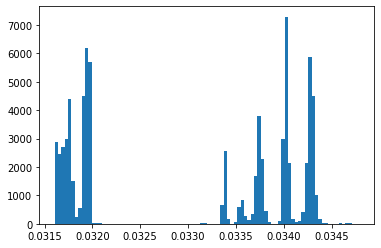

In [37]:

# reshape: soritert Array um, in diesem Fall ganz explizit die Einträge aus dt
# (-1,breath_lengths) meint: egal wie viele es werden (-1), die einzelnen Array Einträge müssen nur breath_length Länge haben.
# median: berechnet den median entlang einer Achse, axis = -1: median über eine breath_length hinweg. (Für alle Atemzüge, gibt ein Array zurück)
# ~train.dt.isna(): Entfernt alle Nan-Werte (entstehen weil vorher negative Werte weggenommen wurden)
dt_median = np.median(np.reshape(train['dt'][~train.dt.isna()].values, (-1, (BREATH_LENGTH - 1))), axis = -1)
plt.hist(dt_median, 90);

Wie hoch ist die Standartabweichung der einzelnen Atemzüge bezüglich der Zeitschrittlängen?

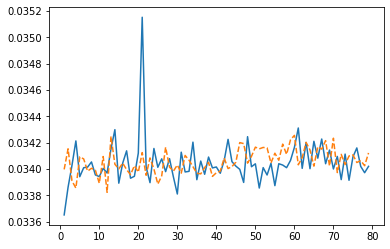

In [38]:
# Na-Werte werden nicht geplottet
first_breath  = train[train['breath_id'] == 1]
second_breath = train[train['breath_id'] == 2]

x = range(BREATH_LENGTH)
dt1 = first_breath['dt']
dt2 = second_breath['dt']
plt.plot(x, dt1)
plt.plot(x, dt2, ls = '--')

Die meisten Atemzüge haben eine kleine Standardabweichung: Wenn sie in einem der Peaks von oben beginnen, enden sie auch in diesem. 

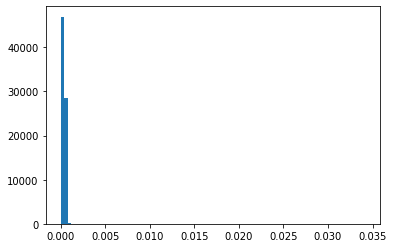

In [39]:
dt_std = np.std(np.reshape(train['dt'][~train.dt.isna()].values, (-1, (BREATH_LENGTH - 1))), axis = -1)
plt.hist(dt_std, 90);

**u_out Ventilator Attribut**

Zwei Beispiel Atemzüge. u_out verändert seinen Wert innerhalb eines Atemzuges.

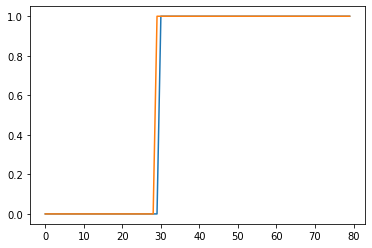

In [40]:
first_u_out  = first_breath['u_out']
second_u_out = second_breath['u_out']
plt.plot(range(BREATH_LENGTH), first_u_out)
plt.plot(range(BREATH_LENGTH), second_u_out)

Wo innerhalb eines Atemzuges schaltet u_out um?

(array([1.0000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 1.2300e+02,
        2.2803e+04, 0.0000e+00, 1.8260e+04, 1.7923e+04, 1.6328e+04]),
 array([25. , 25.7, 26.4, 27.1, 27.8, 28.5, 29.2, 29.9, 30.6, 31.3, 32. ]),
 <BarContainer object of 10 artists>)

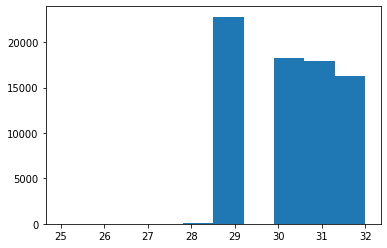

In [41]:
u_out_diff = train['u_out'].diff()
# an dieser Stelle ist der u_out Übergang
u_out_transitions = u_out_diff.index[u_out_diff == 1] % BREATH_LENGTH
plt.hist(u_out_transitions)

Wird u_out irgendwann innerhalb eines Atemzuges von 1 auf 0 geschaltet? Nein.

In [42]:
# assert gibt einen AssertionError, wenn Aussage falsch.
u_out_decreases        = train['u_out'].diff()[1:].values < 0
breath_id_remains_same = train['breath_id'].diff()[1:].values == 0
assert(np.max(u_out_decreases * breath_id_remains_same) == 0)

Wie verhält sich die Lage des Übergangs zu der Länge des Atemzuges? Könnte es sein, dass u_out immer nach der gleichen Zeit umgeschaltet wird?

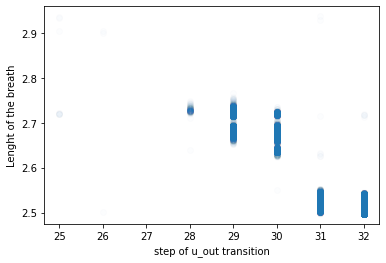

In [43]:
plt.scatter(u_out_transitions, time_step_max, alpha = 0.01);
plt.ylabel('Lenght of the breath')
plt.xlabel('step of u_out transition');

Hier sind die Zeiten der letzten u_out = 0 Werte.

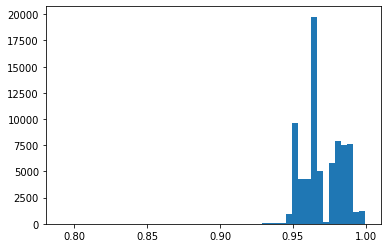

In [44]:
u_out_still_zero = u_out_diff.index[u_out_diff == 1] - 1
times_before_transition = train['time_step'][u_out_still_zero]
plt.hist(times_before_transition, 50)
# gibt Fehler, falls u_out = 1 dabei ist.
assert(max(train['u_out'][u_out_still_zero]) == 0)

Hier ist der erste u_out = 1 Wert.

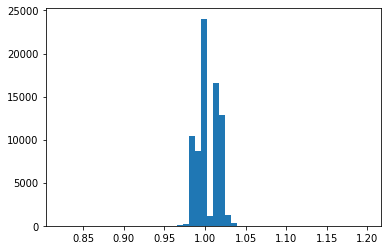

In [45]:
u_out_first_one = u_out_diff.index[u_out_diff == 1]
times_after_transition = train['time_step'][u_out_first_one]
plt.hist(times_after_transition,50)
# gibt Fehler, wenn ein u_out = 0 dabei ist.
assert(min(train['u_out'][u_out_first_one]) == 1)

Schaltet ungefähr bei 0,99 um.

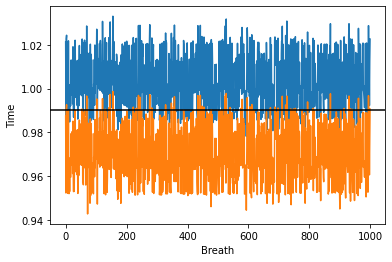

In [46]:
plt.plot(times_after_transition[:1000].values)
plt.plot(times_before_transition[:1000].values)
plt.axhline(0.99, c = 'k');
plt.ylabel('Time');
plt.xlabel('Breath');

**u_in Ventilator Attribut**

Wie spielen u_out und u_in zusammen?

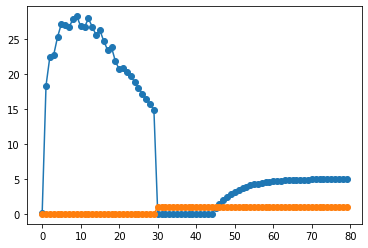

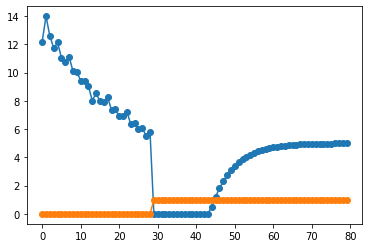

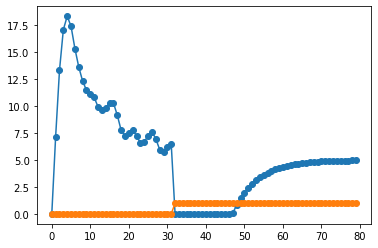

In [47]:
for idx in range(3):
    plt.plot(range(BREATH_LENGTH), train[train['breath_id'] == unique_breaths[idx]]['u_in'], marker = 'o')
    plt.plot(range(BREATH_LENGTH), train[train['breath_id'] == unique_breaths[idx]]['u_out'], marker = 'o')
    plt.show()

Hier ist noch mal der recht gleichförmige Verlauf nach dem Einschalten von u_out zu sehen. 

In [48]:
u_out_transitions

Int64Index([30, 29, 32, 32, 29, 29, 29, 29, 31, 32,
            ...
            29, 31, 30, 31, 32, 29, 30, 30, 31, 30],
           dtype='int64', length=75450)

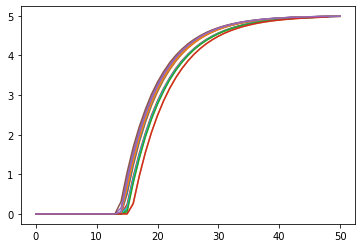

In [49]:
for idx in range(15):
    u_in = train[train['breath_id'] == unique_breaths[idx]]['u_in']
    u_out_transition = u_out_transitions[idx]
    step_since_transition = range(BREATH_LENGTH - u_out_transition)
    plt.plot(step_since_transition, u_in[u_out_transition:])

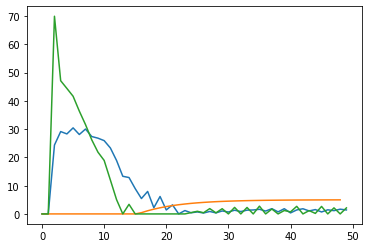

In [50]:
for idx in [15,16,29]:
    u_in = train[train['breath_id'] == unique_breaths[idx]]['u_in']
    u_out_transition = u_out_transitions[idx]
    step_since_transition = range(BREATH_LENGTH - u_out_transition)
    plt.plot(step_since_transition, u_in[u_out_transition:])

Zeit als x-Achse auch nicht besser? Nein.

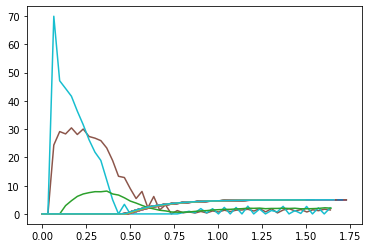

In [51]:
for idx in range(50):
    u_in = train[train['breath_id'] == unique_breaths[idx]]['u_in']
    u_out_transition = u_out_transitions[idx]
    time_steps = train[train['breath_id'] == unique_breaths[idx]]['time_step'].values
    time_since_transition = time_steps - time_steps[u_out_transition]
    plt.plot(time_since_transition[u_out_transition:], u_in[u_out_transition:])

Maxima-Verteilung der u_in Werte. (Maximum pro Atemzug)

Text(0.5, 0, 'max u_in')

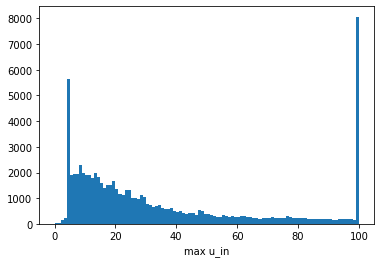

In [52]:
plt.hist(train[['breath_id', 'u_in']].groupby('breath_id').max()['u_in'], 100);
plt.xlabel('max u_in')

**Pressure**

Durchschnittlicher Atemzug. (Durchschnittlicher Druck über alle Atemzüge an jedem Datenpunkt einzeln)

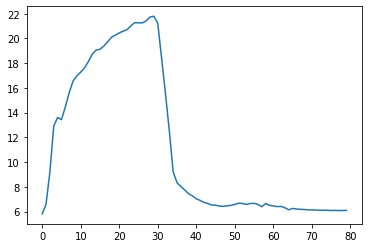

In [53]:
avgs = np.zeros(BREATH_LENGTH)
for t in range(BREATH_LENGTH):
    avgs[t] = train['pressure'][t::BREATH_LENGTH].mean()
plt.plot(avgs)

Negativer Druck

In [54]:
len(train[train['pressure'] <= 0])

3713

In [55]:
negative_pressure_breaths = train[train['pressure'] <= 0]['breath_id'].unique()
negative_pressure_breaths

array([   542,    851,   3928,   7949,  11216,  13594,  16599,  19236,
        20075,  22164,  23710,  27195,  27731,  30127,  36474,  40431,
        40753,  43103,  43630,  44309,  45099,  45681,  45877,  46018,
        46020,  46486,  47325,  49376,  49941,  50459,  52137,  53057,
        54206,  56152,  56760,  57119,  58835,  59101,  60949,  65596,
        67080,  67788,  70753,  71461,  72011,  74977,  77803,  83713,
        85391,  86508,  90584,  91132,  91464,  92955,  94037,  97520,
        98041,  98080, 101951, 106703, 108406, 109424, 109761, 110499,
       111419, 112036, 113323, 113639, 118131, 119582, 120445, 121570,
       124575])

u_in für alle nagetiven Druck-Datenpunkte

Text(0.5, 0, 'max u_in for negative pressure')

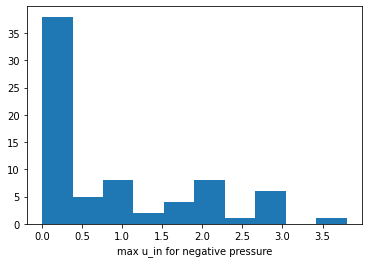

In [56]:
max_u_in_for_negative_pressure_breaths = [train[train['breath_id'] == b]['u_in'].max() for b in negative_pressure_breaths]
plt.hist(max_u_in_for_negative_pressure_breaths);
plt.xlabel('max u_in for negative pressure')

Initialer Druck (bei Datenpunkt 0) für jeden Atemzug

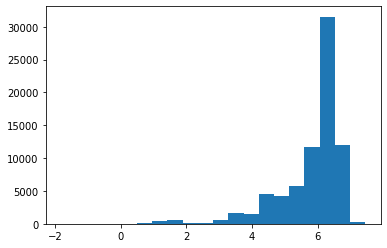

In [57]:
initial_pressure = train['pressure'][::BREATH_LENGTH]
plt.hist(initial_pressure,20);

Woher kommt der?

u_in reicht nicht aus. 

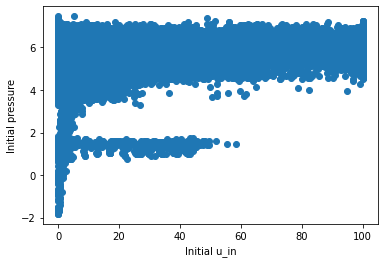

In [58]:
initial_u_in = train['u_in'][::BREATH_LENGTH]
plt.scatter(initial_u_in, initial_pressure);
plt.ylabel('Initial pressure')
plt.xlabel('Initial u_in');

R und C Werte gegen Initialen Druck geplottet.

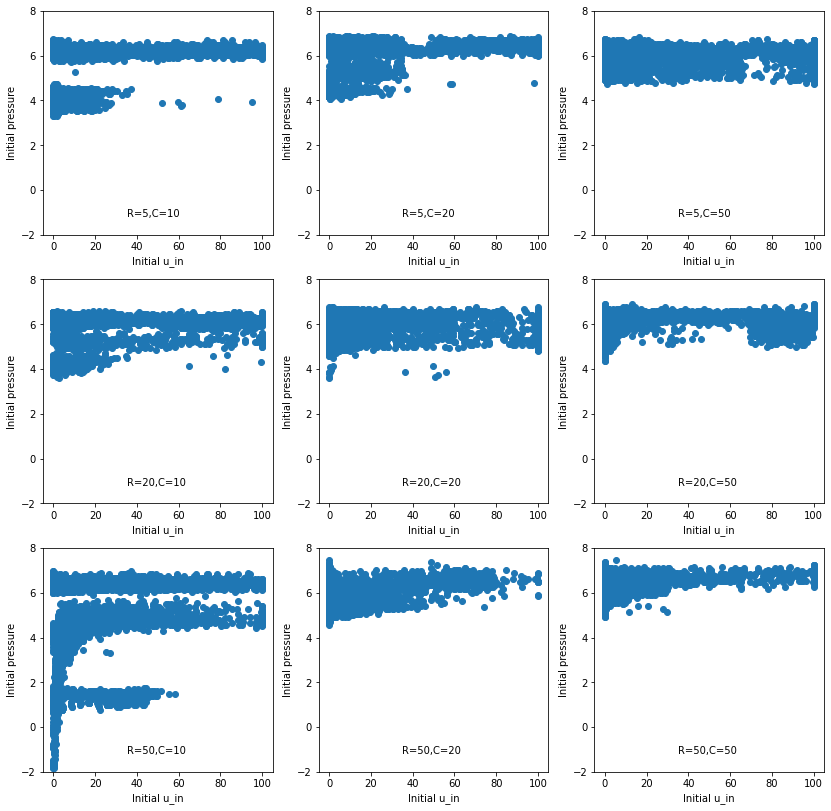

In [59]:
fig, axs = plt.subplots(len(r_unique), len(c_unique), figsize=(14,14))
for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        axs[i,j].scatter(foo['u_in'][::BREATH_LENGTH], foo['pressure'][::BREATH_LENGTH]);
        # macht, dass alle gleich skaliert sind
        axs[i,j].set_ylim([-2,8])
        axs[i,j].text(35,-1.2,f'R={r},C={c}')
        axs[i,j].set_ylabel('Initial pressure')
        axs[i,j].set_xlabel('Initial u_in');

noch mal ohne u_in. War wie oben schon gesagt, nicht so wichtig. 

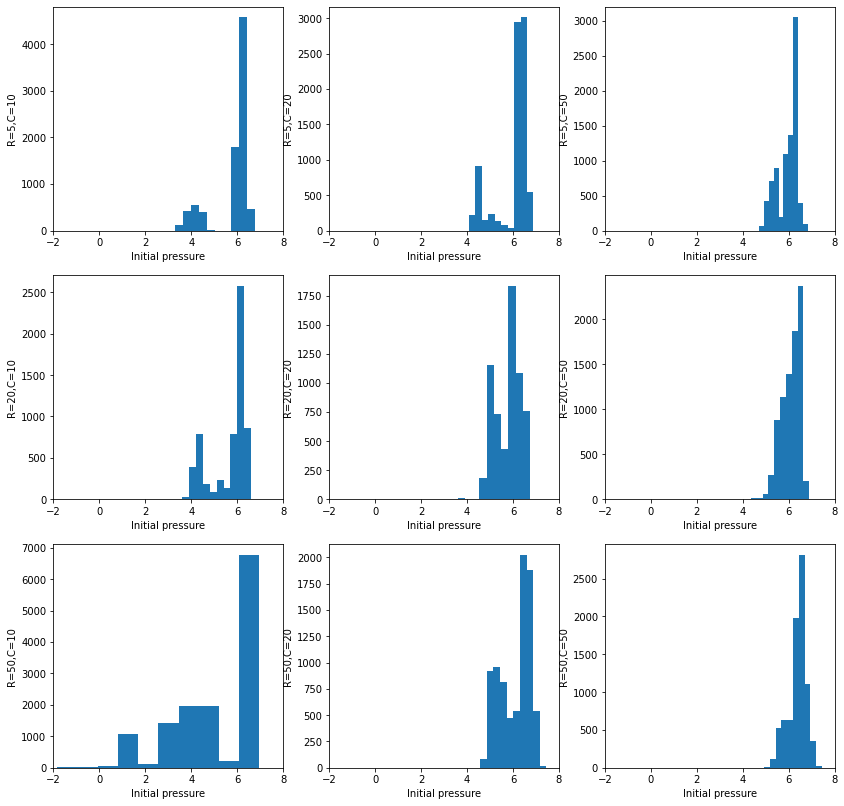

In [60]:
fig, axs = plt.subplots(len(r_unique), len(c_unique), figsize=(14,14))
for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        axs[i,j].hist(foo['pressure'][::BREATH_LENGTH]);
        axs[i,j].set_xlim([-2,8])
        axs[i,j].set_ylabel(f'R={r},C={c}')
        axs[i,j].set_xlabel('Initial pressure');

Viele Atemzüge über die Zeit mit verschiedenen R und C Werten. In Rot: Start der Ausatmenphase.

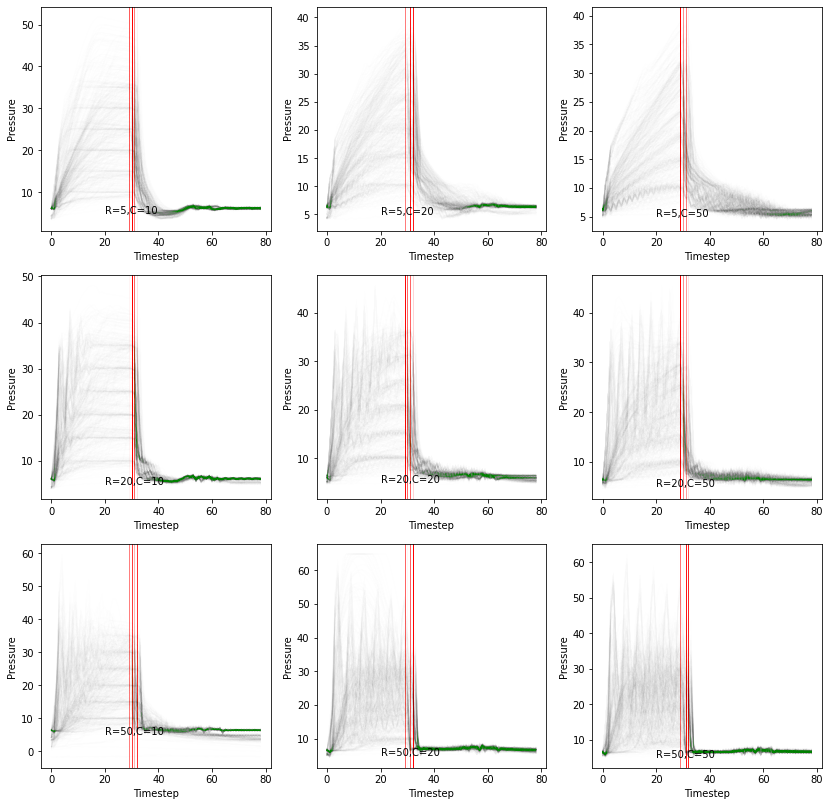

In [61]:
fig, axs = plt.subplots(len(r_unique), len(c_unique), figsize=(14,14))
for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        for k in range(600):
            kter_breath = foo[k*BREATH_LENGTH:k*BREATH_LENGTH+79]
            u_out_diff = kter_breath['u_out'].diff()
            u_out_first_one = (u_out_diff.index[u_out_diff == 1] % BREATH_LENGTH).max()
            axs[i,j].plot(range(79), kter_breath['pressure'], c = 'g', alpha = 0.005);
            axs[i,j].axvline(u_out_first_one, color = 'r', lw = 1, alpha = 0.005)
        axs[i,j].text(20,5,f'R={r},C={c}')
        axs[i,j].set_ylabel('Pressure')
        axs[i,j].set_xlabel('Timestep');    


Wie hängt da jetzt u_in drin?

/var/folders/yq/5gn_k7n55gq6r095zlq10sww0000gn/T/ipykernel_87080/2022057526.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


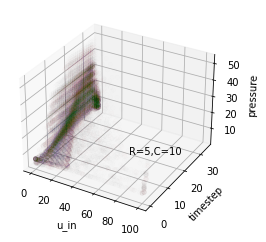

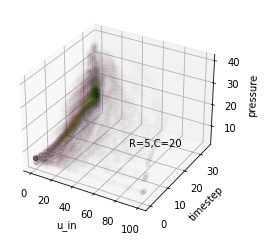

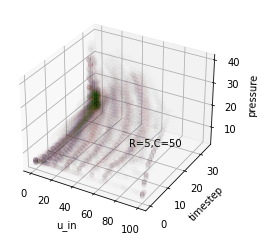

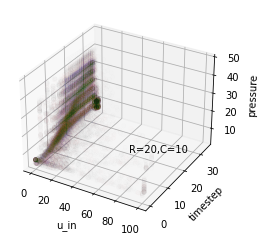

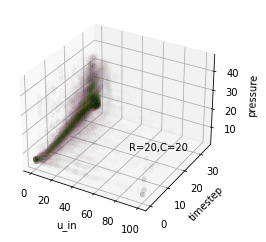

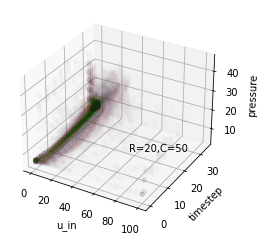

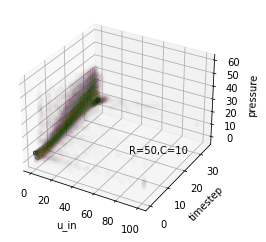

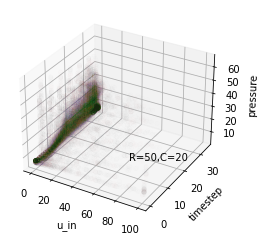

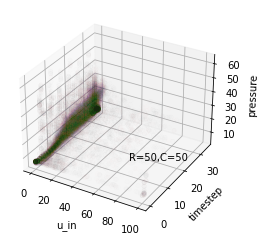

In [62]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        threedee = plt.figure().gca(projection='3d')
        # den ersten Atemzug für alle R-C-Möglichkeiten
        for k in range(600):
            kter_breath = foo[k*BREATH_LENGTH:k*BREATH_LENGTH+35]
            ys = kter_breath['pressure']
            xs = range(35)
            zs = kter_breath['u_in']
            threedee.scatter(zs, xs, ys, alpha = 0.005)
        threedee.set_xlabel('u_in')
        threedee.set_ylabel('timestep')
        threedee.set_zlabel('pressure')
        threedee.text(80,5,20,f'R={r},C={c}')
        plt.show()

hübsch, aber nicht so viel Erkenntnis. 

/var/folders/yq/5gn_k7n55gq6r095zlq10sww0000gn/T/ipykernel_87080/3920691312.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d', xlim=(0,25))


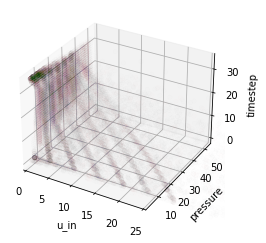

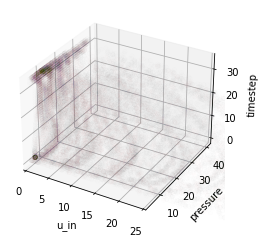

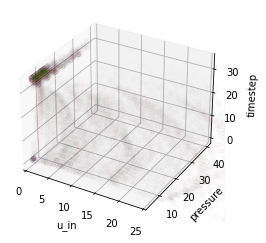

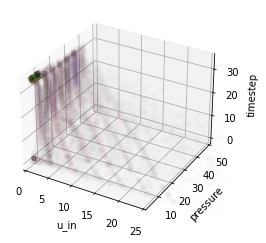

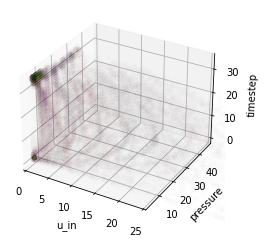

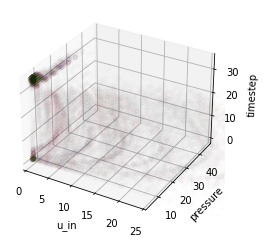

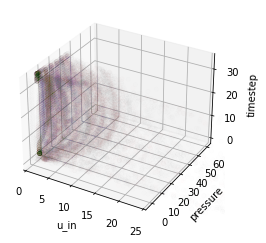

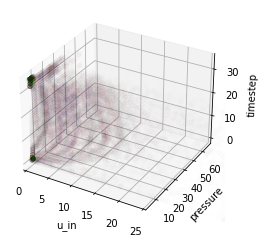

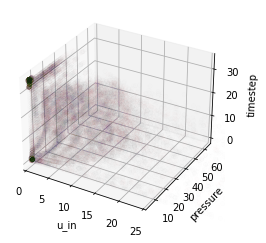

In [63]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        threedee = plt.figure().gca(projection='3d', xlim=(0,25))
        # den ersten Atemzug für alle R-C-Möglichkeiten
        for k in range(600):
            kter_breath = foo[k*BREATH_LENGTH:k*BREATH_LENGTH+35]
            ys = kter_breath['pressure']
            xs = range(35)
            zs = kter_breath['u_in']
            threedee.scatter(zs, ys, xs, alpha = 0.005)
        threedee.set_xlabel('u_in')
        threedee.set_ylabel('pressure')
        threedee.set_zlabel('timestep')
        threedee.text(80,5,20,f'R={r},C={c}')
        plt.show()

mehr u_in Plots.

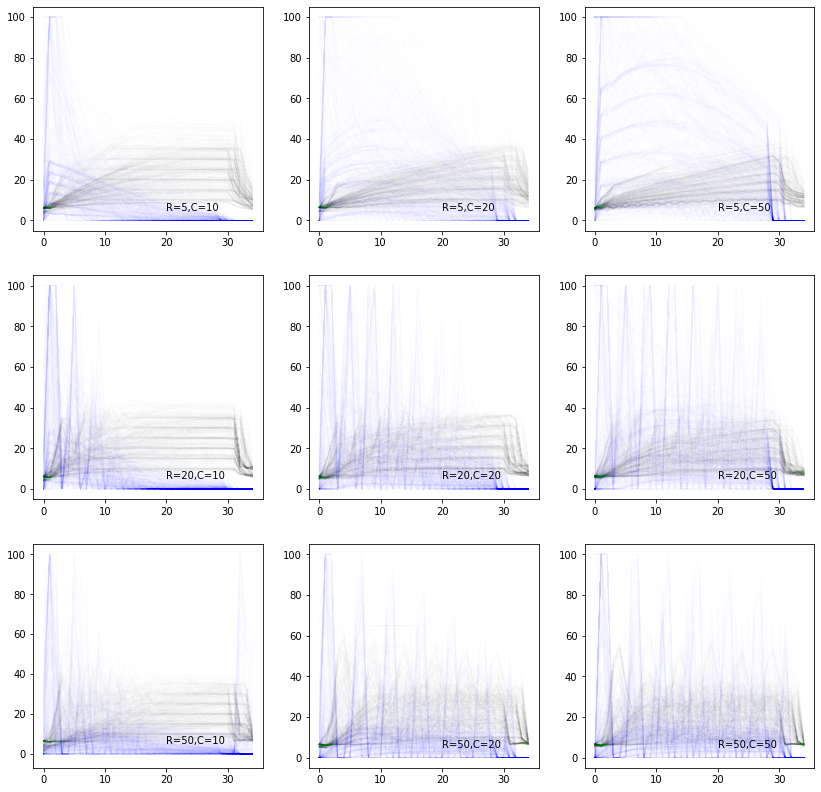

In [64]:
fig, axs = plt.subplots(len(r_unique), len(c_unique), figsize=(14,14))
for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        for k in range(600):
            kter_breath = foo[k*BREATH_LENGTH:k*BREATH_LENGTH+35]
            axs[i,j].plot(range(35), kter_breath['pressure'], c = 'g', alpha = 0.005);
            axs[i,j].plot(range(35), kter_breath['u_in'], c = 'b', alpha = 0.005);
        axs[i,j].text(20,5,f'R={r},C={c}')    

Kein offensichtlicher Zusammenhang. 

**Erste Lineare Regeression**

u_in vrs. Pressure

neues Feature: fortlaufende Summe pro Atmenzug über u_in

In [65]:
def u_in_cumsum_per_breath(df : pd.DataFrame) -> pd.DataFrame:
    '''
    Includes new feature cummulative sum of feature u_in. 

    Args:
        df: Dataframe to use. Must inclide column u_in and breath_id.

    Returns:
        Dataframe with new feature u_in_cumsum.
    '''
    df['u_in_cumsum'] = df.groupby('breath_id')['u_in'].cumsum()
    return df

In [66]:
#feature engineering
train = u_in_cumsum_per_breath(train)
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,dt,u_in_cumsum
0,1,1,20,50,0.000000,0.083334,0,5.837492,NaN,0.083334
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.033652,18.466375
2,3,1,20,50,0.067514,22.509278,0,7.876254,0.033862,40.975653
3,4,1,20,50,0.101542,22.808822,0,11.742872,0.034028,63.784476
4,5,1,20,50,0.135756,25.355850,0,12.234987,0.034213,89.140326


Die Prediction soll nur auf dem Einatmen passieren, dh, alle Werte wo u_out = 1 ist werden weggelassen. 

In [67]:
def filter_inhalation(df : pd.DataFrame) -> pd.DataFrame:
    '''
    Filters Dataframe for inhalation. 

    Ars:
        df: Dataframe that gets filtered. Needs to indluce column u_out.
    
    Returns:
        Dataframe for inhalation, u_out = 0.
    '''
    # reset_index vergibt einen neuen fortlaufenden Standartindex und löscht die Zeile mit dem alten Index.
    df = df[df["u_out"] == 0].reset_index(drop=True)
    return df

In [68]:
in_df = filter_inhalation(train)
in_df.head(37)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,dt,u_in_cumsum
0,1,1,20,50,0.000000,0.083334,0,5.837492,NaN,0.083334
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.033652,18.466375
2,3,1,20,50,0.067514,22.509278,0,7.876254,0.033862,40.975653
3,4,1,20,50,0.101542,22.808822,0,11.742872,0.034028,63.784476
4,5,1,20,50,0.135756,25.355850,0,12.234987,0.034213,89.140326
5,6,1,20,50,0.169698,27.259866,0,12.867706,0.033942,116.400192
6,7,1,20,50,0.203708,27.127486,0,14.695562,0.034010,143.527677
7,8,1,20,50,0.237723,26.807732,0,15.890699,0.034015,170.335409
8,9,1,20,50,0.271776,27.864715,0,15.539188,0.034054,198.200124
9,10,1,20,50,0.305732,28.313036,0,15.750094,0.033955,226.513160


Erste Lineare Regression mit sklearn

Daten einfach so wie sie sind.

In [69]:
def data_preparation_sklearn(df : pd.DataFrame, u_cumsum : bool) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Data preparation for Linear Regression with sklearn

    Args:
        df: Dataframe for prediction.
        u_in: Decides whether to use the cumulative sum of u_in or use just u_in

    Returns:
        Tupel of Numpyarrays in the following order: x_train, x_test, y_train, y_test
    '''
    y = in_df.pressure
    x = in_df.drop(['id', 'breath_id', 'u_in_cumsum', 'dt', 'pressure'], axis=1)
    a = train_test_split(x, y, test_size=0.3, random_state=1)
    if u_cumsum:
        x = in_df.drop(['id', 'breath_id', 'dt', 'u_in', 'u_out', 'pressure'], axis=1)
        a = train_test_split(x, y, test_size=0.3, random_state=1)
    return a

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = data_preparation_sklearn(in_df, False)
x_train.shape, x_test.shape

((1603677, 5), (687291, 5))

In [71]:
def linear_regression_sklearn(x_train : np.ndarray, y_train : np.ndarray) -> LinearRegression:
    '''
    Fits Linear regression to train-data.

    Args:
        x_train und y_train: data to train. 

    Returns:
        a Linear Regression model.
    '''
    lr = LinearRegression()
    return lr.fit(x_train, y_train)

In [72]:
def predict_sklearn(model : LinearRegression, x_test : np.ndarray) -> int:
    '''
    Makes prediction for the given model over the test-data

    Args:
        model: the given Model for prediction.
        x_test: testdata for which to make predictions.

    Returns:
        the mean-sqaured-error for the prediction for the test-data.
    '''
    return mean_squared_error(y_test, model.predict(x_test), squared=False)

In [73]:
model = linear_regression_sklearn(x_train, y_train)
# R-square geht von 0 bis 1 und sagt wie gut das Modell an die Daten passt.
print("R_square: " ,model.score(x_test, y_test))

print("RMSE: ", predict_sklearn(model, x_test))

R_square:  0.2545710140351436
RMSE:  7.990441158725478


mit u_in_cumsum

In [74]:

x2_train, x2_test, y2_train, y2_test = data_preparation_sklearn(in_df, True)

model2 = linear_regression_sklearn(x2_train, y2_train)
print("R_square: " ,model2.score(x2_test, y2_test))
print("RMSE: ", predict_sklearn(model2, x2_test))

R_square:  0.4755023965232452
RMSE:  6.702539370232926


Lineare Regression mit Pytorch

In [75]:
import torch
import torch.nn.functional as F
import torch.nn as nn

Splitten der Trainingsdaten. Parameter nach Vorlesung gewählt

macht aus dem DataFrame ein NumPy-Array

In [78]:
def data_preparation_pytorch(df : pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Prepared Data for Linear Regression and brings it in the right shape to use with PyTorch.

    Args:
        
    '''
    y = in_df.pressure
    x = in_df.drop(['id', 'breath_id', 'u_in_cumsum', 'dt', 'pressure'], axis=1)
    x = np.array(x, dtype=np.float64)
    y = np.array(y,dtype=np.float64)
    return train_test_split(x, y, test_size=0.2, random_state=0)

In [79]:
x_train, x_test, y_train, y_test = data_preparation_pytorch(in_df)
x_train, x_test, y_train, y_test

(array([[ 5.        , 50.        ,  0.23809552, 72.24390251,  0.        ],
        [ 5.        , 50.        ,  0.17262459, 45.52866754,  0.        ],
        [ 5.        , 10.        ,  0.        ,  0.6707207 ,  0.        ],
        ...,
        [20.        , 50.        ,  0.37357545, 18.09892463,  0.        ],
        [ 5.        , 50.        ,  0.74006844, 41.70495903,  0.        ],
        [ 5.        , 50.        ,  0.25748038, 18.39939487,  0.        ]]),
 array([[ 5.        , 20.        ,  0.51006842, 92.71631375,  0.        ],
        [50.        , 20.        ,  0.63998961,  0.        ,  0.        ],
        [20.        , 20.        ,  0.28914309, 23.22665454,  0.        ],
        ...,
        [50.        , 10.        ,  0.41107917,  0.        ,  0.        ],
        [ 5.        , 20.        ,  0.79777145, 30.35417041,  0.        ],
        [50.        , 10.        ,  0.63510108,  0.        ,  0.        ]]),
 array([13.5707277 , 10.68833974,  6.32960672, ..., 23.20212163,
     

Um PyTorch nutzen zu können müssen die Daten in eine Tensorform gebracht werden. (mein Laptop hat keine Cuda-fähige GPU, daher verzichte ich auf den to-Anhang)

In [80]:

train_x = torch.tensor(x_train).float()
test_x = torch.tensor(x_test).float()
train_y =torch.tensor(y_train).float()
train_y = torch.reshape(train_y,(train_y.shape[0],1))
test_y = torch.tensor(y_test).float()
test_y = torch.reshape(test_y,(test_y.shape[0],1))
train_x.shape, test_x.shape, train_y.shape, test_y.shape

(torch.Size([1832774, 5]),
 torch.Size([458194, 5]),
 torch.Size([1832774, 1]),
 torch.Size([458194, 1]))

Model-Definition der Linearen Regression

Modell-Training.

Bemerkungen: epoch: Maß, wie oft alle Daten verwendet werden sollen. 

In [81]:
def linear_regression_pytorch(input_size : int, output_size : int, num_epochs : int, learning_rate : int, x_train : torch.Tensor, y_train :torch.Tensor) -> nn.Linear:
    input_size = input_size
    output_size = output_size
    model = nn.Linear(input_size , output_size)

    # definiere Parameter welche für das Training erfordlerich sind
    num_epochs = num_epochs
    learning_rate = learning_rate
    loss_func = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate )

    for epoch in range(num_epochs):

        #output
        y_pred = model(x_train.requires_grad_())

        # Berechnet den Verlust (loss)
        loss= loss_func(y_pred, y_train)

        # Backprooagation, hier werden die Gradienten berechnet
        loss.backward()

        # hier werden die Gewichte aktualisiert
        optimizer.step()

            # setzte Gradienten wieder auf 0
        optimizer.zero_grad()

        if epoch % 100 == 0:
            print(f"Loss in epoch {epoch} is {loss.item()}")
    return model

In [82]:

model = linear_regression_pytorch(5, 1, 10000, 0.0005, train_x, train_y)


Loss in epoch 0 is 348.9184265136719
Loss in epoch 100 is 129.9044189453125
Loss in epoch 200 is 126.99687957763672
Loss in epoch 300 is 124.2204360961914
Loss in epoch 400 is 121.5687255859375
Loss in epoch 500 is 119.03611755371094
Loss in epoch 600 is 116.61722564697266
Loss in epoch 700 is 114.30694580078125
Loss in epoch 800 is 112.10035705566406
Loss in epoch 900 is 109.9927749633789
Loss in epoch 1000 is 107.97969818115234
Loss in epoch 1100 is 106.0569076538086
Loss in epoch 1200 is 104.2203140258789
Loss in epoch 1300 is 102.46604919433594
Loss in epoch 1400 is 100.79037475585938
Loss in epoch 1500 is 99.18978118896484
Loss in epoch 1600 is 97.66085052490234
Loss in epoch 1700 is 96.20036315917969
Loss in epoch 1800 is 94.80520629882812
Loss in epoch 1900 is 93.47245025634766
Loss in epoch 2000 is 92.19926452636719
Loss in epoch 2100 is 90.98299407958984
Loss in epoch 2200 is 89.82102966308594
Loss in epoch 2300 is 88.71096801757812
Loss in epoch 2400 is 87.65042114257812
Loss

In [83]:
def predict_pytorch(x_test : torch.Tensor, y_test: torch.Tensor, model : nn.Linear) -> int:
    '''
    makes predicitons for the given model on test-data.

    Args:
        x_test, y_test: test-data to be predicted. 
        model: given model for predictions

    Returns: 
        the mean-sqaured-error for the prediction for the test-data.
    '''
    return mean_squared_error(y_test.detach().numpy(), model(x_test).detach().numpy(), squared=False)

In [84]:
print("RMSE: ", predict_pytorch(test_x, test_y, model))

RMSE:  8.089693


Weiter mit LSTM im Notebook LSTM-trained!